In [32]:
from __future__ import annotations
import os, sys, json
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from glob import glob

with open(os.getcwd().replace(r'\Analise', '') + '\\config.json') as config_file:
    config = json.load(config_file)
    sys.path.append(config['caminho_rede'])

from Arquivos.ColetaDados.ToolsColeta import MainParameters


column_len = 200

pl.Config.set_fmt_str_lengths(column_len)  # Ajuste o valor de acordo com a sua necessidade
pd.set_option('display.max_colwidth', column_len)  # Altere 200 conforme necessário

warnings.filterwarnings("ignore")
proj_dir = os.getcwd().replace(r'\Arquivos\Analise', '')


# Análise Exploratória dos Dados Sócio-Econômicos dos Municípios do ZEEC-ES 

## Censo 2022

### População

Distribuição da população por grupo de idade


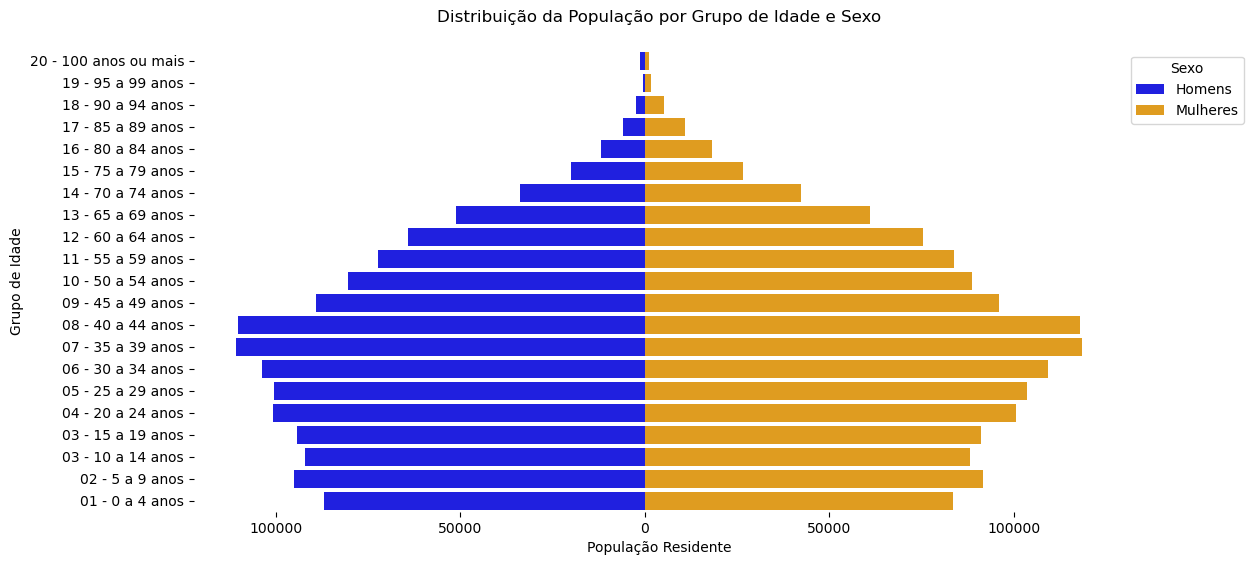

Ideia: colocar linha da pirâmide etária de 2010. (Jornal Nexo)


In [16]:

def create_age_distribution(female_df, male_df, year):
    male_color = 'blue'
    female_color = 'orange'
    df_f = female_df.loc[::-1]
    df_m = male_df.loc[::-1]
    ax = sns.barplot(y=df_m["grupo_idade"], x=df_m['populacao_residente'], orient="h", color="blue", label="Homens")
    sns.barplot(y=df_f["grupo_idade"], x=df_f['populacao_residente'], orient="h", color="orange", label="Mulheres")
    
    # Inverter o eixo y para a ordem correta
    plt.gca().invert_yaxis()

    # Remover as linhas de margem e os eixos
    sns.despine(left=True, bottom=True)
    # plt.axis('off')

    # Personalizar os rótulos do eixo x para que apareçam como positivos
    x_labels = ax.get_xticks()

    ax.set_xticklabels([int(abs(x)) for x in x_labels])

    # Adicionar legenda
    plt.legend(title="Sexo", loc="upper right")
    
    # Adicionar título e rótulos
    plt.title('Distribuição da População por Grupo de Idade e Sexo', pad=20)
    plt.xlabel('População Residente')
    plt.ylabel('Grupo de Idade')
    # plt.legend()
    
    return ax


df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Censo Pop', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])

df = df.with_columns(
    pl.when(pl.col('sexo') == 'Homens')
      .then(pl.col('populacao_residente') * -1)
      .otherwise(pl.col('populacao_residente'))
      .alias('populacao_residente')
)

df = df.with_columns((pl.col('grupo_idade').replace('0 a 4 anos', '01 - 0 a 4 anos')
                                           .replace('5 a 9 anos', '02 - 5 a 9 anos')
                                           .replace('10 a 14 anos', '03 - 10 a 14 anos')
                                           .replace('15 a 19 anos', '03 - 15 a 19 anos')
                                           .replace('20 a 24 anos', '04 - 20 a 24 anos')
                                           .replace('25 a 29 anos', '05 - 25 a 29 anos')
                                           .replace('30 a 34 anos', '06 - 30 a 34 anos')
                                           .replace('35 a 39 anos', '07 - 35 a 39 anos')
                                           .replace('40 a 44 anos', '08 - 40 a 44 anos')
                                           .replace('45 a 49 anos', '09 - 45 a 49 anos')
                                           .replace('50 a 54 anos', '10 - 50 a 54 anos')
                                           .replace('55 a 59 anos', '11 - 55 a 59 anos')
                                           .replace('60 a 64 anos', '12 - 60 a 64 anos')
                                           .replace('65 a 69 anos', '13 - 65 a 69 anos')
                                           .replace('70 a 74 anos', '14 - 70 a 74 anos')
                                           .replace('75 a 79 anos', '15 - 75 a 79 anos')
                                           .replace('80 a 84 anos', '16 - 80 a 84 anos')
                                           .replace('85 a 89 anos', '17 - 85 a 89 anos')
                                           .replace('90 a 94 anos', '18 - 90 a 94 anos')
                                           .replace('95 a 99 anos', '19 - 95 a 99 anos')
                                           .replace('100 anos ou mais', '20 - 100 anos ou mais'))
)


print('Distribuição da população por grupo de idade')

# Continuar usando o dataframe df_grouped que já agrupa por grupo de idade e sexo
df_grouped = df.group_by(['grupo_idade', 'sexo']) \
          .agg([pl.sum("populacao_residente").alias("populacao_residente")]) \
          .sort(['grupo_idade', 'sexo'], descending=True)


df_fem = df_grouped.filter(pl.col('sexo').str.contains("Mulheres")).to_pandas()
df_men = df_grouped.filter(pl.col('sexo').str.contains("Homens")).to_pandas()


# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário
ax = create_age_distribution(df_fem, df_men, year=2022)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Sexo')
plt.show()


print('Ideia: colocar linha da pirâmide etária de 2010. (Jornal Nexo)')

### Alfabetização

In [17]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Censo Alfabetizados', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])


print('Média Aritmética de Alfabetização nos Municípios')
display(df.with_columns(pl.col("taxa_alfabetizacao").replace('-', None).cast(pl.Float64))
          .drop_nulls('taxa_alfabetizacao')\
          .group_by(['cor_raca', 'grupo_idade']) \
          .agg([pl.mean("taxa_alfabetizacao").alias("taxa_alfabetizacao")]) \
          .sort(['taxa_alfabetizacao'], descending=False) \
          .head(10))

Média Aritmética de Alfabetização nos Municípios


cor_raca,grupo_idade,taxa_alfabetizacao
str,str,f64
"""Preta""","""80 anos ou mais""",50.042381
"""Preta""","""75 anos ou mais""",52.694419
"""Parda""","""80 anos ou mais""",59.451364
"""Preta""","""65 anos ou mais""",63.146818
"""Parda""","""75 anos ou mais""",63.669091
"""Indígena""","""75 anos ou mais""",65.556667
"""Indígena""","""80 anos ou mais""",66.294583
"""Indígena""","""65 anos ou mais""",69.283243
"""Parda""","""65 anos ou mais""",73.34


### Abastecimento de Água

In [18]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Censo Agua', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])

print('Domicílios por grupo de abastecimento')
display(df.group_by(['tipo_ligacao_rede_geral']) \
          .agg([pl.sum("domicilios").alias("tipo_ligacao")]) \
          .sort("tipo_ligacao", descending=True) \
          .with_columns(pl.col("tipo_ligacao").cast(pl.Int32)) \
          .head(10))

print('Total de domicílios: ', df['domicilios'].sum())

display('"Possui ligação à rede": ', df.filter(pl.col('tipo_ligacao_rede_geral').str.contains("Possui ligação à rede"))
                                 .select(pl.col('domicilios'))
                                 .sum()/df['domicilios'].sum())
display('"Possui ligação à rede como forma principal": ', df.filter(pl.col('tipo_ligacao_rede_geral').str.contains("Possui ligação à rede geral e a utiliza como forma principal"))
                                 .select(pl.col('domicilios'))
                                 .sum()/df['domicilios'].sum())

display('"NÃO possui ligação à rede": ', df.filter(pl.col('tipo_ligacao_rede_geral').str.contains("Não possui"))
                                 .select(pl.col('domicilios'))
                                 .sum()/df['domicilios'].sum())


Domicílios por grupo de abastecimento


tipo_ligacao_rede_geral,tipo_ligacao
str,i32
"""Possui ligação à rede geral e a utiliza como forma principal""",934018
"""Não possui ligação com a rede geral""",64343
"""Não possui ligação com a rede geral - Poço profundo ou artesiano""",38196
"""Possui ligação à rede geral, mas utiliza principalmente outra forma""",17839
"""Não possui ligação com a rede geral - Poço raso, freático ou cacimba""",16834
"""Possui ligação à rede geral, mas utiliza principalmente outra forma - Poço profundo ou artesiano""",14700
"""Não possui ligação com a rede geral - Fonte, nascente ou mina""",6247
"""Possui ligação à rede geral, mas utiliza principalmente outra forma - Poço raso, freático ou cacimba""",1889
"""Não possui ligação com a rede geral - Outra""",1344


Total de domicílios:  1098382


'"Possui ligação à rede": '

domicilios
f64
0.88284


'"Possui ligação à rede como forma principal": '

domicilios
f64
0.850358


'"NÃO possui ligação à rede": '

domicilios
f64
0.11716


### Saneamento

In [19]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Censo Esgoto', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])

print('Domicílios por grupo de saneamento')
display(df.group_by(['tipo_esgotamento_sanitario']) \
          .agg([pl.sum("domicilios").alias("tipo_ligacao")]) \
          .sort("tipo_ligacao", descending=True) \
          .with_columns(pl.col("tipo_ligacao").cast(pl.Int32)) \
          .head(10))

print('Total de domicílios: ', df['domicilios'].sum())

display('"Possui ligação à rede geral": ', df.filter(pl.col('tipo_esgotamento_sanitario').str.contains("Rede geral"))
                                 .select(pl.col('domicilios'))
                                 .sum()/df['domicilios'].sum())
display('"Possui sistema ligado à rede": ', df.filter(pl.col('tipo_esgotamento_sanitario').str.contains_any(["Rede geral, rede pluvial", 
                                                                                                                           'Fossa séptica ou fossa filtro ligada à rede']))
                                 .select(pl.col('domicilios'))
                                 .sum()/df['domicilios'].sum())

display('"NÃO possui sistema ligado à rede": ', 1+(df.filter(pl.col('tipo_esgotamento_sanitario').str.contains_any(["Rede geral, rede pluvial", 
                                                                                                                                   'Fossa séptica ou fossa filtro ligada à rede']))
                                 .select(pl.col('domicilios'))
                                 .sum()*-1 )/df['domicilios'].sum())

Domicílios por grupo de saneamento


tipo_esgotamento_sanitario,tipo_ligacao
str,i32
"""Rede geral, rede pluvial ou fossa ligada à rede""",826351
"""Rede geral ou pluvial""",813041
"""Fossa rudimentar ou buraco""",92124
"""Fossa séptica ou fossa filtro não ligada à rede""",67236
"""Vala""",17667
"""Fossa séptica ou fossa filtro ligada à rede""",13310
"""Rio, lago, córrego ou mar""",9553
"""Outra forma""",2809
"""Não tinham banheiro nem sanitário""",460


Total de domicílios:  1842551


'"Possui ligação à rede geral": '

domicilios
f64
0.88974


'"Possui sistema ligado à rede": '

domicilios
f64
0.455706


'"NÃO possui sistema ligado à rede": '

domicilios
f64
0.544294


## Acesso à Internet e Conectividade

### Densidade de Acessos

Estatística Descritiva da Densidade de Acessos à Internet (agregado 2021/01-2024/02), % domicilios com acesso à internet


statistic,value
str,f64
"""count""",722.0
"""null_count""",0.0
"""mean""",18.710582
"""std""",8.437458
"""min""",2.81
"""25%""",12.59
"""50%""",17.47
"""75%""",24.3
"""max""",77.99


Ranking de Densidade de Acessos em 2024/02


densidade,id_municipio_nome,ano,mes
f64,str,i64,i64
39.36,"""Vitória""",2024,2
31.63,"""Vila Velha""",2024,2
30.23,"""Guarapari""",2024,2
28.04,"""Cachoeiro de Itapemirim""",2024,2
28.0,"""Piúma""",2024,2
27.32,"""Cariacica""",2024,2
25.23,"""Linhares""",2024,2
24.47,"""Marataízes""",2024,2
22.91,"""Serra""",2024,2


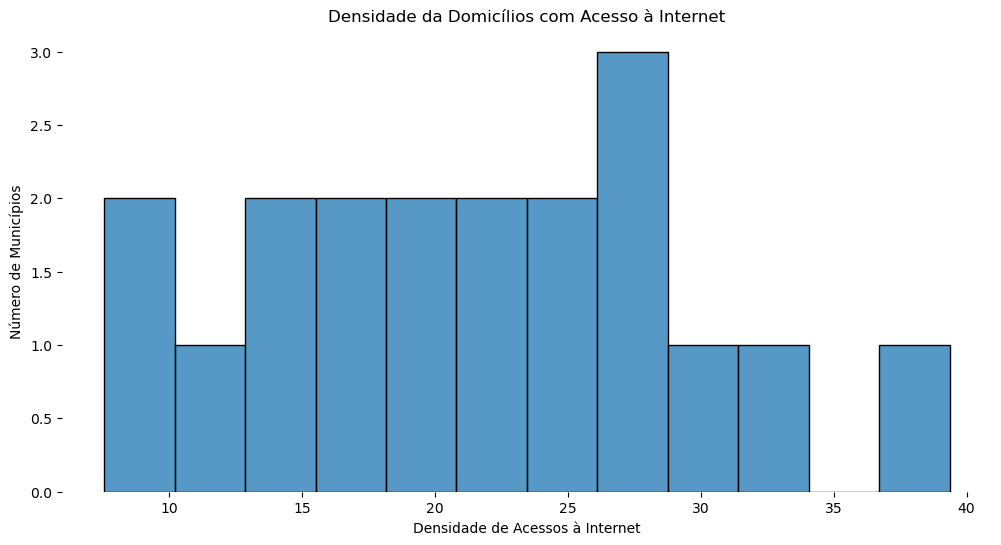

In [20]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Densidade Internet', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])


print('Estatística Descritiva da Densidade de Acessos à Internet (agregado 2021/01-2024/02), % domicilios com acesso à internet')
display(df['densidade'].round(2).describe())


print('Ranking de Densidade de Acessos em 2024/02')
display(df.filter((pl.col("ano") == 2024) & (pl.col('mes') == 2)) \
           .select(["densidade", "id_municipio_nome", 'ano', 'mes']) \
           .with_columns(pl.col("densidade").round(2)) \
           .sort("densidade", descending=True) \
           .head(10))


# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário
sns.histplot(df.filter((pl.col("ano") == 2024) & (pl.col('mes') == 2))['densidade'], bins=12)

# Adicionando os rótulos personalizados
plt.ylabel('Número de Municípios')
plt.xlabel('Densidade de Acessos à Internet')
plt.title('Densidade da Domicílios com Acesso à Internet')
sns.despine(left=True, bottom=True)


plt.show()

### Empresas e Fornecedores

In [21]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Banda Larga', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])

print('Pontos de acessos em 2024')
df_acessos = df.filter(pl.col('ano') == 2024)\
          .group_by(['transmissao', 'velocidade']) \
          .agg([pl.sum("acessos").alias("acessos")]) \
          .with_columns((pl.col("acessos") / pl.col("acessos").sum()).alias('acessos %').round(4)) \
          .sort("acessos", descending=True)

display(df_acessos.head(10))

print('Concentração de fornecedores em 2024')
df_supp = df.filter(pl.col('ano') == 2024)\
          .group_by(['empresa', 'porte_empresa']) \
          .agg([pl.sum("acessos").alias("acessos")]) \
          .with_columns((pl.col("acessos") / pl.col("acessos").sum()).alias('market share').round(4)) \
          .sort("acessos", descending=True)

display(df_supp.head(10))
print('soma top 10: ', df_supp.head(10).sum())

print('Total de fornecedores: ', df_supp['empresa'].count())


Pontos de acessos em 2024


transmissao,velocidade,acessos,acessos %
str,str,i64,f64
"""Fibra""","""> 34Mbps""",1042423,0.7268
"""Cabo Coaxial""","""> 34Mbps""",250762,0.1748
"""Fibra""","""12Mbps a 34Mbps""",37193,0.0259
"""Radio""","""512kbps a 2Mbps""",35089,0.0245
"""Fibra""","""2Mbps a 12Mbps""",10792,0.0075
"""Cabo Metalico""","""12Mbps a 34Mbps""",10010,0.007
"""Cabo Metalico""","""2Mbps a 12Mbps""",9172,0.0064
"""Fibra""","""512kbps a 2Mbps""",7893,0.0055
"""Radio""","""2Mbps a 12Mbps""",7848,0.0055


Concentração de fornecedores em 2024


empresa,porte_empresa,acessos,market share
str,str,i64,f64
"""VIVO""","""Grande Porte""",282822,0.1972
"""CLARO""","""Grande Porte""",272607,0.1901
"""OI""","""Grande Porte""",250509,0.1747
"""GIGA MAIS FIBRA""","""Pequeno Porte""",154401,0.1077
"""R7 TELECOMUNICACOES LTDA""","""Pequeno Porte""",111524,0.0778
"""KORE BRASIL LTDA""","""Pequeno Porte""",34752,0.0242
"""Megalink Servicos Ltda""","""Pequeno Porte""",34160,0.0238
"""REAL LIFE COMERCIO E SERVICOS LTDA-ME""","""Pequeno Porte""",20506,0.0143
"""Brasil Radiowave Ltda""","""Pequeno Porte""",13551,0.0094


soma top 10:  shape: (1, 4)
┌─────────┬───────────────┬─────────┬──────────────┐
│ empresa ┆ porte_empresa ┆ acessos ┆ market share │
│ ---     ┆ ---           ┆ ---     ┆ ---          │
│ str     ┆ str           ┆ i64     ┆ f64          │
╞═════════╪═══════════════╪═════════╪══════════════╡
│ null    ┆ null          ┆ 1186548 ┆ 0.8274       │
└─────────┴───────────────┴─────────┴──────────────┘
Total de fornecedores:  237


## CAGED

Estatística Descritiva de Horas Semanais de Trabalho e Salário Mensal (2021/01 - 2024-01)


statistic,idade,horas_contratuais,salario_mensal
str,f64,f64,f64
"""count""",2.252148e6,2.251231e6,2.251118e6
"""null_count""",122.0,1039.0,1152.0
"""mean""",32.575487,42.003108,1913.407382
"""std""",10.980623,6.50628,15812.227172
"""min""",14.0,0.0,0.0
"""25%""",24.0,44.0,1285.07
"""50%""",31.0,44.0,1416.5
"""75%""",40.0,44.0,1866.18
"""max""",93.0,60.0,1.3341412e7


Contratações (2021/01 - 2024-01)


id_municipio_nome,total_movimentacao
str,i32
"""Serra""",271989
"""Vitória""",236912
"""Vila Velha""",183983
"""Cariacica""",99362
"""Linhares""",87097
"""Aracruz""",76608
"""Cachoeiro de Itapemirim""",60161
"""São Mateus""",43909
"""Guarapari""",35140


Demissões/Saídas (2021/01 - 2024-01)


id_municipio_nome,total_movimentacao
str,i32
"""Serra""",-247145
"""Vitória""",-213303
"""Vila Velha""",-165388
"""Cariacica""",-89661
"""Linhares""",-79585
"""Aracruz""",-68968
"""Cachoeiro de Itapemirim""",-54378
"""São Mateus""",-37834
"""Guarapari""",-31052


Distribuição de Salários em 2024/01 (trimmed em 1%)


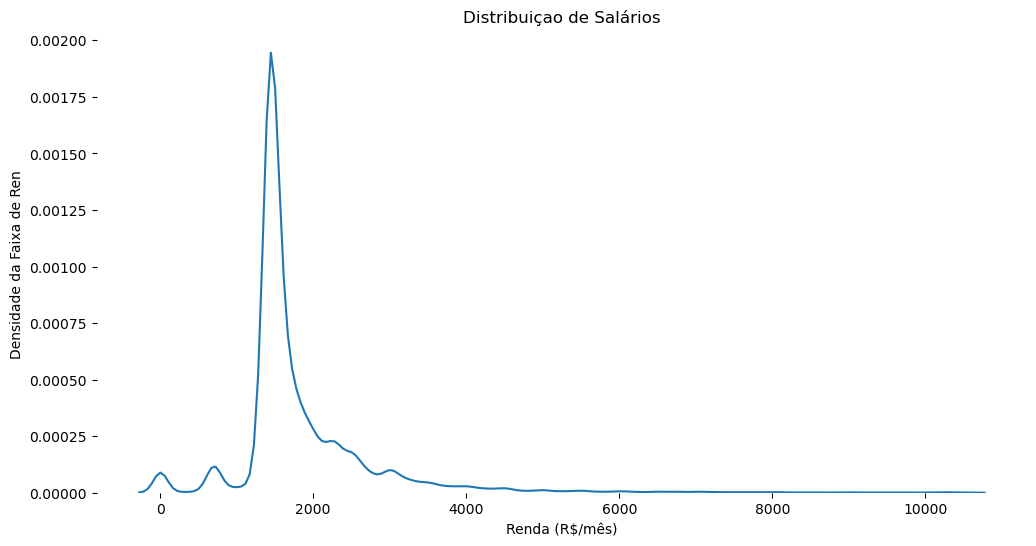

In [22]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'CAGED', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])


print('Estatística Descritiva de Horas Semanais de Trabalho e Salário Mensal (2021/01 - 2024-01)')
display(df[['idade', 'horas_contratuais', 'salario_mensal']].describe())

print('Contratações (2021/01 - 2024-01)')
display(df.filter(pl.col('saldo_movimentacao') == 1)\
          .group_by("id_municipio_nome") \
          .agg([pl.sum("saldo_movimentacao").alias("total_movimentacao")]) \
          .sort("total_movimentacao", descending=True) \
          .with_columns(pl.col("total_movimentacao").cast(pl.Int32)) \
          .head(10))

print('Demissões/Saídas (2021/01 - 2024-01)')
display(df.filter(pl.col('saldo_movimentacao') == -1)\
          .group_by("id_municipio_nome") \
          .agg([pl.sum("saldo_movimentacao").alias("total_movimentacao")]) \
          .sort("total_movimentacao", descending=False) \
          .with_columns(pl.col("total_movimentacao").cast(pl.Int32)) \
          .head(10))

# Filtrar apenas os valores do ano 2024
df_2024 = df.filter(pl.col("ano") == 2024)

# Calcular os quantis de 1% e 99% (extremos a serem removidos)
q_low = df_2024['salario_mensal'].quantile(0.005)
q_high = df_2024['salario_mensal'].quantile(0.995)

# Filtrar os dados para remover os valores fora do intervalo dos 2% extremos
df_filtered = df_2024.filter(
    (pl.col("salario_mensal") >= q_low) & (pl.col("salario_mensal") <= q_high))


# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário
print('Distribuição de Salários em 2024/01 (trimmed em 1%)')
sns.kdeplot(df_filtered['salario_mensal'])
plt.ylabel('Densidade da Faixa de Ren ')
plt.xlabel('Renda (R$/mês)')
plt.title('Distribuiçao de Salários')
sns.despine(left=True, bottom=True)

## RAIS

Estatística Descritiva de Quantidade de Vínculos Ativos e CLTistas (2022)


statistic,quantidade_vinculos_ativos,quantidade_vinculos_clt
str,f64,f64
"""count""",233584.0,233584.0
"""null_count""",0.0,0.0
"""mean""",6.156132,5.480345
"""std""",70.093124,36.674641
"""min""",0.0,0.0
"""25%""",0.0,0.0
"""50%""",1.0,1.0
"""75%""",3.0,3.0
"""max""",15423.0,5263.0


Distribuição de Vínculos Ativos


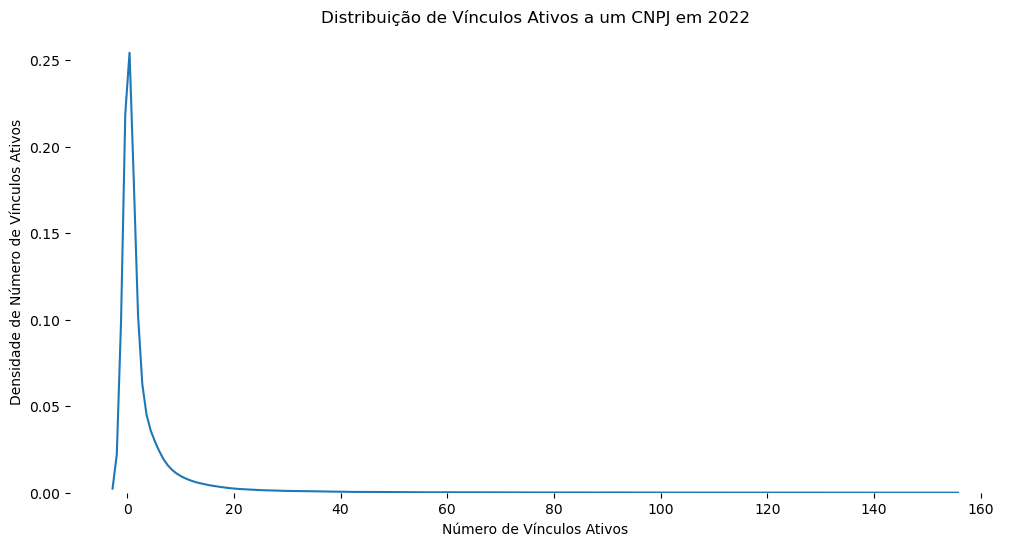

In [23]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'RAIS', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])


print('Estatística Descritiva de Quantidade de Vínculos Ativos e CLTistas (2022)')
display(df.filter(pl.col('ano') == 2022)[['quantidade_vinculos_ativos', 'quantidade_vinculos_clt']].describe())


# Filtrar apenas os valores do ano 2022
df_2022 = df.filter(pl.col("ano") == 2022)

# Calcular os quantis de 1% e 99% (extremos a serem removidos)
q_low = df_2022['quantidade_vinculos_ativos'].quantile(0.005)
q_high = df_2022['quantidade_vinculos_ativos'].quantile(0.995)

# Filtrar os dados para remover os valores fora do intervalo dos 2% extremos
df_filtered = df_2022.filter(
    (pl.col("quantidade_vinculos_ativos") >= q_low) & (pl.col("quantidade_vinculos_ativos") <= q_high))


# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário
print('Distribuição de Vínculos Ativos')
sns.kdeplot(df_filtered['quantidade_vinculos_ativos'])
plt.ylabel('Densidade de Número de Vínculos Ativos')
plt.xlabel('Número de Vínculos Ativos')
plt.title('Distribuição de Vínculos Ativos a um CNPJ em 2022')
sns.despine(left=True, bottom=True)

## CNPJs 

10 Maiores CNAES em 2024/08


cnae_fiscal,num_cnpjs,nome
str,u32,str
"""4722902""",624,"""Peixaria"""
"""5590699""",503,"""Outros alojamentos não especificados anteriormente"""
"""5510801""",403,"""Hotéis"""
"""4763604""",194,"""Comércio varejista de artigos de caça, pesca e camping"""
"""7912100""",160,"""Operadores turísticos"""
"""0810006""",142,"""Extração de areia, cascalho ou pedregulho e beneficiamento associado"""
"""5232000""",109,"""Atividades de agenciamento marítimo"""
"""0810002""",98,"""Extração de granito e beneficiamento associado"""
"""0600001""",78,"""Extração de petróleo e gás natural"""


Número de Estabelecimentos em 2024


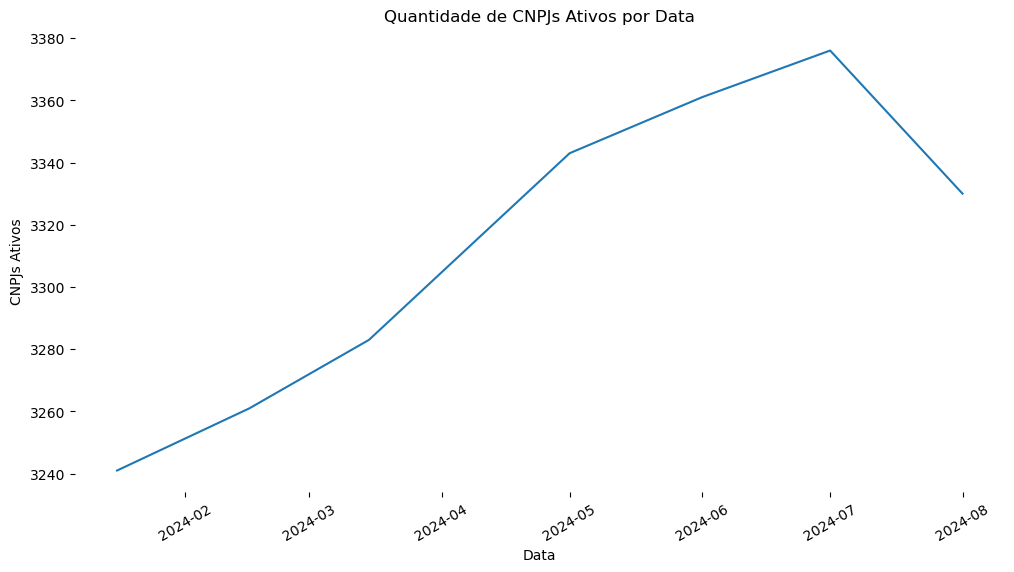

In [24]:
param = MainParameters()

def insert_cnpjs_link(ano:int, meses:list):
    df = pl.DataFrame()
    str_dtype = pl.String

    for mes in meses:
        file = os.path.join(r'C:\Users\galve\MyDrive\Carreira\ObservatorioES\Dados\Cnpj Estabelecimentos', f'cnpj_estabelecimentos_{ano}_{mes}.parquet')
        # Read each Parquet file with Polars
        cnpj_df = pl.read_parquet(file)

        # Rename columns as per your requirement
        cnpj_df = cnpj_df.rename({'uf': 'sigla_uf'})
        

        df = pl.concat([df, cnpj_df])

    df_mun = pl.read_csv(os.path.join(proj_dir, 'Dados', 'Cnpj Empresas', 'dict_municipios.csv'), 
                             encoding= 'latin1', 
                             schema={'':str_dtype,  'id_municipio_rf': str_dtype,	'id_municipio_nome': str_dtype,	
                                    'id_municipio': str_dtype, 'sigla_uf': str_dtype})
    df = df.join(df_mun, on='id_municipio_rf', how='left')

    # df = df.drop('cnpj_basico', 'cnpj_ordem', 'cnpj_dv', 'matriz_filial', 'id_municipio', 'sigla_uf_right',
    #              'tipo_logradouro', 'logradouro', 'numero', 'complemento', '')
    
    df = df[['data', 'cnpj', 'situacao_cadastral', 'data_situacao_cadastral', 'motivo_situacao_cadastral', 'data_inicio_atividade', 'cnae_fiscal_secundaria', 
             'sigla_uf', 'id_municipio_rf', 'bairro', 'cep', 'cnae_fiscal', 'id_municipio_nome']]
    #        .with_columns([pl.col("data").str.strptime(pl.Date, format="%Y-%m-%d").alias("data"),
    #                       pl.col("data_inicio_atividade").cast(pl.Date),
    #                       pl.col("data_situacao_cadastral").cast(pl.Date)            
    #                       ])
    df = df.filter((pl.col('id_municipio_rf').str.contains_any(list(param.cod_rf()))) & 
                    pl.col('cnae_fiscal').str.contains_any(param.cnae_analise()))


    return df



def insert_cnpjs_bd(anos: list, chunksize: int = 500000):

    df = pl.DataFrame()
    for ano in anos:
        file = os.path.join(proj_dir, 'Dados', 'Cnpj Estabelecimentos', f'cnpj_estabelecimentos_{ano}.parquet')
        # Read the Parquet file using Polars
        cnpj_df = pl.read_parquet(file)

        # Renomear ou excluir colunas conforme necessário
        cnpj_df = cnpj_df.drop(['cnae_fiscal_principal', 'uf', 'id_municipio_nome_right'])
        df = pl.concat([df, cnpj_df])
        df = df.filter((pl.col('id_municipio_rf').str.contains_any(list(param.cod_rf()))) & 
                        pl.col('cnae_fiscal').str.contains_any(param.cnae_analise()))

    return df

df_link = insert_cnpjs_link(2024, ['05', '06', '07', '08'])
df_bd = insert_cnpjs_bd([2024])
df = pl.concat([df_bd, df_link])

cnae_dict = {'cnae': 'nome',
            '4722902': 'Peixaria',
            "5590699":	'Outros alojamentos não especificados anteriormente',
            "5510801":	'Hotéis',
            "4763604":	'Comércio varejista de artigos de caça, pesca e camping',
            "7912100":	'Operadores turísticos',
            "0810006":	'Extração de areia, cascalho ou pedregulho e beneficiamento associado',
            "5232000":	'Atividades de agenciamento marítimo',
            "0810002":	'Extração de granito e beneficiamento associado',
            "0600001":	'Extração de petróleo e gás natural',
            "7420002": 'Atividades de produção de fotografias aéreas e submarinas'}
cnae = pl.DataFrame(cnae_dict)
cnae = cnae.transpose(include_header=True, column_names=['nome'])

print('10 Maiores CNAES em 2024/08')
display(df.filter((pl.col('situacao_cadastral').str.contains_any(['Ativa', '02']))
                  & (pl.col('data') >= pl.date(2024, 8, 1)))\
          .group_by(["cnae_fiscal"]) \
          .agg([pl.count("cnpj").alias("num_cnpjs")]) \
          .sort("num_cnpjs", descending=True) \
          .head(10).join(cnae, how='left', left_on='cnae_fiscal', right_on='column'))

print('Número de Estabelecimentos em 2024')
df_tline = df.filter((pl.col('situacao_cadastral').str.contains_any(['Ativa', '02'])))\
          .group_by(["data"]) \
          .agg([pl.count("cnpj").alias("num_cnpjs")]) \
          .sort("data", descending=False) 

# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário
sns.lineplot(data=df_tline, y=df_tline['num_cnpjs'], x=df_tline['data'])
plt.ylabel('CNPJs Ativos')
plt.xlabel('Data')
plt.title('Quantidade de CNPJs Ativos por Data')
plt.xticks(rotation=30)
sns.despine(left=True, bottom=True)

## Educação

### Índice de Desenvolvimento da Educação Básica

Nota SAEB e Taxa de Aprovação nas Escolas por Ano e Município


,id_municipio_nome,ano,nota_saeb,taxa_aprovacao
0,Fundão,2021,5.243090,97.510000
1,Conceição da Barra,2021,5.285210,97.416000
2,Sooretama,2021,5.364532,98.492857
3,Cariacica,2021,5.436772,97.736111
4,Jaguaré,2021,5.484111,96.820000
5,São Mateus,2021,5.577797,94.708333
6,Vila Velha,2021,5.578597,96.446032
7,Cachoeiro de Itapemirim,2021,5.578953,97.568132
8,Itapemirim,2021,5.619574,91.100000
9,Viana,2021,5.620809,98.422222


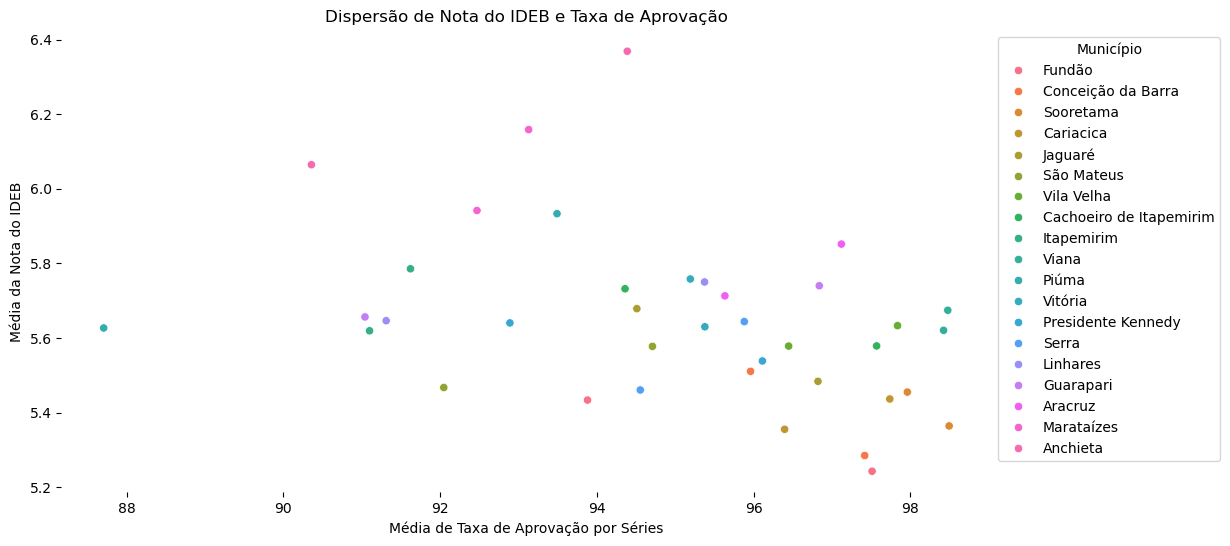

In [25]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Educ Base', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])


print('Nota SAEB e Taxa de Aprovação nas Escolas por Ano e Município')
df_tline = df.group_by(['id_municipio_nome', 'ano']) \
          .agg([pl.mean("nota_saeb_media_padronizada").alias("nota_saeb"), pl.mean("taxa_aprovacao").alias("taxa_aprovacao")]) \
          .sort(['ano', 'nota_saeb', ], descending=False).to_pandas() 


display(df_tline)
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário
ax = sns.scatterplot(data=df_tline, y=df_tline['nota_saeb'], x=df_tline['taxa_aprovacao'], hue=df_tline['id_municipio_nome'])
plt.ylabel('Média da Nota do IDEB')
plt.xlabel('Média de Taxa de Aprovação por Séries')
plt.title('Dispersão de Nota do IDEB e Taxa de Aprovação')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Município')
sns.despine(left=True, bottom=True)

### Enem

Notas por Raça/Cor e Ano


,ano,cor_raca,Nota Matemática,Nota Linguagens,Nota Ciências Humanas,Nota Ciências Naturais,Nota Redação
0,2021,Amarela,522.848485,488.996887,506.472763,494.518182,585.680934
1,2021,Branca,590.917150,533.476366,552.853195,528.654706,692.255581
2,2021,Indígena,494.037288,467.502564,465.815385,459.366102,532.307692
3,2021,Não declarado,564.070968,519.205660,537.074214,510.955484,642.138365
4,2021,Parda,538.238071,500.178655,513.649414,490.129040,615.605797
5,2021,Preta,519.976827,491.716351,504.360179,475.676594,594.060823
6,2022,Amarela,527.201365,499.896865,512.752978,490.457679,573.166144
7,2022,Branca,601.261129,547.377378,560.816265,527.157430,706.920559
8,2022,Indígena,518.978723,492.192000,515.218000,463.208511,586.800000
9,2022,Não declarado,564.601880,538.229682,542.867845,515.003008,654.558304


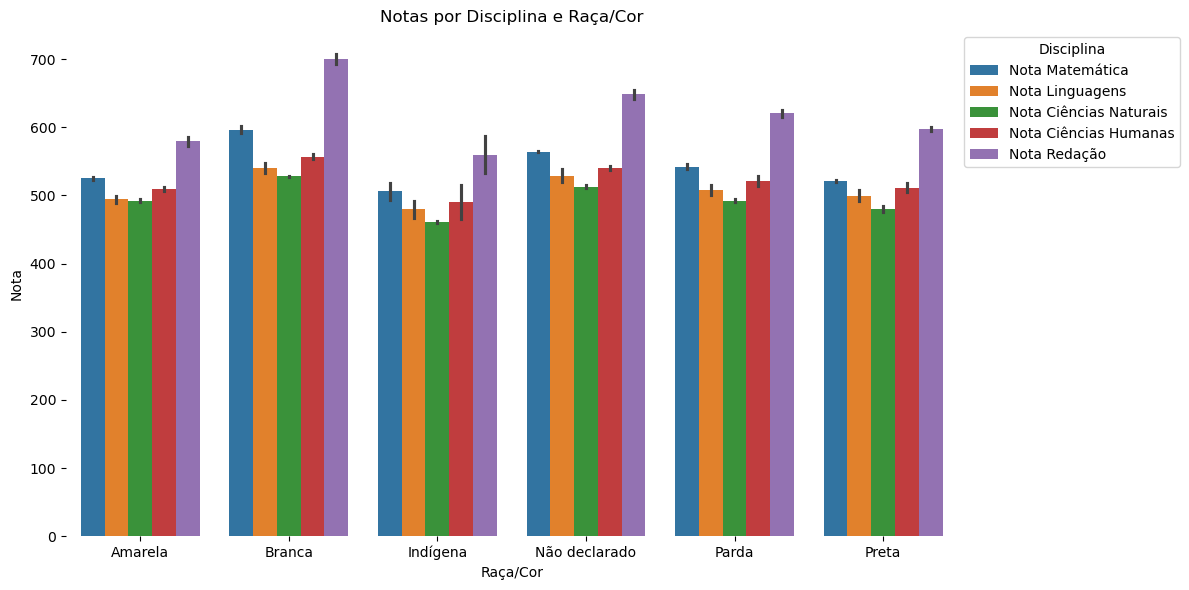

In [26]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Enem', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])

print('Notas por Raça/Cor e Ano')
df_tline = df.group_by(['ano', 'cor_raca',]) \
          .agg([pl.mean("nota_matematica").alias("Nota Matemática"), 
                pl.mean("nota_linguagens_codigos").alias("Nota Linguagens"), 
                pl.mean("nota_ciencias_humanas").alias("Nota Ciências Humanas"), 
                pl.mean("nota_ciencias_natureza").alias("Nota Ciências Naturais"), 
                pl.mean(['nota_redacao']).alias("Nota Redação"), 
                ])\
          .sort(['ano', 'cor_raca', 'Nota Matemática', ], descending=False).to_pandas() 

display(df_tline)
# Exemplo de como derreter o DataFrame para visualização
df_melted = df_tline.melt(id_vars=['cor_raca'], 
                          value_vars=['Nota Matemática', 'Nota Linguagens', 
                                      'Nota Ciências Naturais', 'Nota Ciências Humanas',  'Nota Redação'],
                          var_name='disciplina', value_name='nota')


# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário

# Gerar o gráfico com as barras lado a lado para cada raça
ax = sns.barplot(data=df_melted, x='cor_raca', y='nota', hue='disciplina')
ax.set_title("Notas por Disciplina e Raça/Cor")
ax.set_xlabel("Raça/Cor")
ax.set_ylabel("Nota")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Disciplina')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()




### Censo do Ensino Superior

In [27]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Cursos Superiores', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])


print('Número de Cursos em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_ies_nome']) \
          .agg([pl.count("id_curso").alias("Quantidade Cursos"), 
                ])\
          .sort(['ano', 'Quantidade Cursos', 'id_ies_nome', ], descending=True).to_pandas() 
display(df_tline)

print('Número de IES em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_ies_tipo_instituicao']) \
          .agg([pl.count("id_ies").alias("Quantidade IES"), 
                ])\
          .sort(['ano', 'Quantidade IES', 'id_ies_tipo_instituicao', ], descending=True).to_pandas() 

display(df_tline)

print('Quantidade de Vagas em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_ies_tipo_instituicao']) \
          .agg([pl.sum("quantidade_vagas").alias("Quantidade Vagas"), 
                ])\
          .sort(['ano', 'Quantidade Vagas', 'id_ies_tipo_instituicao', ], descending=True).to_pandas() 

display(df_tline)

print('Quantidade de Inscritos em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_ies_tipo_instituicao']) \
          .agg([pl.sum("quantidade_inscritos").alias("Quantidade Inscritos"), 
                ])\
          .sort(['ano', 'Quantidade Inscritos', 'id_ies_tipo_instituicao', ], descending=True).to_pandas() 

display(df_tline)


Número de Cursos em 2022


,ano,id_ies_nome,Quantidade Cursos
0,2022,Centro Universitário Leonardo Da Vinci,904
1,2022,Universidade Pitágoras Unopar Anhanguera,821
2,2022,Centro Universitário Internacional,695
3,2022,Universidade Cesumar,672
4,2022,Universidade Estácio De Sá,660
...,...,...,...
133,2022,Faculdade Brasileira De Cachoeiro,1
134,2022,Escola De Direito Fucape,1
135,2022,Centro Universitário Unibta,1
136,2022,Centro Universitário Planalto Do Distrito Federal - Uniplan,1


Número de IES em 2022


,ano,id_ies_tipo_instituicao,Quantidade IES
0,2022,Privada,8831
1,2022,Público,148


Quantidade de Vagas em 2022


,ano,id_ies_tipo_instituicao,Quantidade Vagas
0,2022,Privada,69649
1,2022,Público,7797


Quantidade de Inscritos em 2022


,ano,id_ies_tipo_instituicao,Quantidade Inscritos
0,2022,Privada,75668
1,2022,Público,61981


### IES

In [28]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Ies', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])


print('Número de Docentes em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_municipio_nome']) \
          .agg([pl.sum("quantidade_docentes").alias("Quantidade Docentes"), 
                ])\
          .sort(['ano', 'Quantidade Docentes', ], descending=True).to_pandas() 
display(df_tline)

print('Número de Docentes Doutores em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_municipio_nome']) \
          .agg([pl.sum("quantidade_docentes_exercicio_doutorado").alias("Quantidade Doutores"), 
                ])\
          .sort(['ano', 'Quantidade Doutores', ], descending=True).to_pandas() 

display(df_tline)

print('Número de Docentes Mestres em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_municipio_nome']) \
          .agg([pl.sum("quantidade_docentes_exercicio_mestrado").alias("Quantidade Mestres"), 
                ])\
          .sort(['ano', 'Quantidade Mestres', ], descending=True).to_pandas() 

display(df_tline)

print('Número de Docentes Especialistas em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_municipio_nome']) \
          .agg([pl.sum("quantidade_docentes_exercicio_especializacao").alias("Quantidade Especialistas"), 
                ])\
          .sort(['ano', 'Quantidade Especialistas', ], descending=True).to_pandas() 

display(df_tline)

Número de Docentes em 2022


,ano,id_municipio_nome,Quantidade Docentes
0,2022,Vitória,4214
1,2022,Vila Velha,582
2,2022,Serra,453
3,2022,Cachoeiro de Itapemirim,329
4,2022,Guarapari,243
5,2022,São Mateus,151
6,2022,Linhares,148
7,2022,Cariacica,115
8,2022,Aracruz,56


Número de Docentes Doutores em 2022


,ano,id_municipio_nome,Quantidade Doutores
0,2022,Vitória,2502
1,2022,Vila Velha,177
2,2022,Guarapari,145
3,2022,Serra,107
4,2022,Linhares,48
5,2022,Cachoeiro de Itapemirim,48
6,2022,São Mateus,39
7,2022,Cariacica,17
8,2022,Aracruz,8


Número de Docentes Mestres em 2022


,ano,id_municipio_nome,Quantidade Mestres
0,2022,Vitória,1232
1,2022,Vila Velha,297
2,2022,Serra,248
3,2022,Cachoeiro de Itapemirim,118
4,2022,Guarapari,64
5,2022,São Mateus,63
6,2022,Cariacica,61
7,2022,Linhares,55
8,2022,Aracruz,36


Número de Docentes Especialistas em 2022


,ano,id_municipio_nome,Quantidade Especialistas
0,2022,Vitória,327
1,2022,Cachoeiro de Itapemirim,161
2,2022,Serra,95
3,2022,Vila Velha,77
4,2022,Linhares,45
5,2022,São Mateus,44
6,2022,Guarapari,34
7,2022,Cariacica,30
8,2022,Aracruz,10


## Dados Econômicos Municipais

### PIB

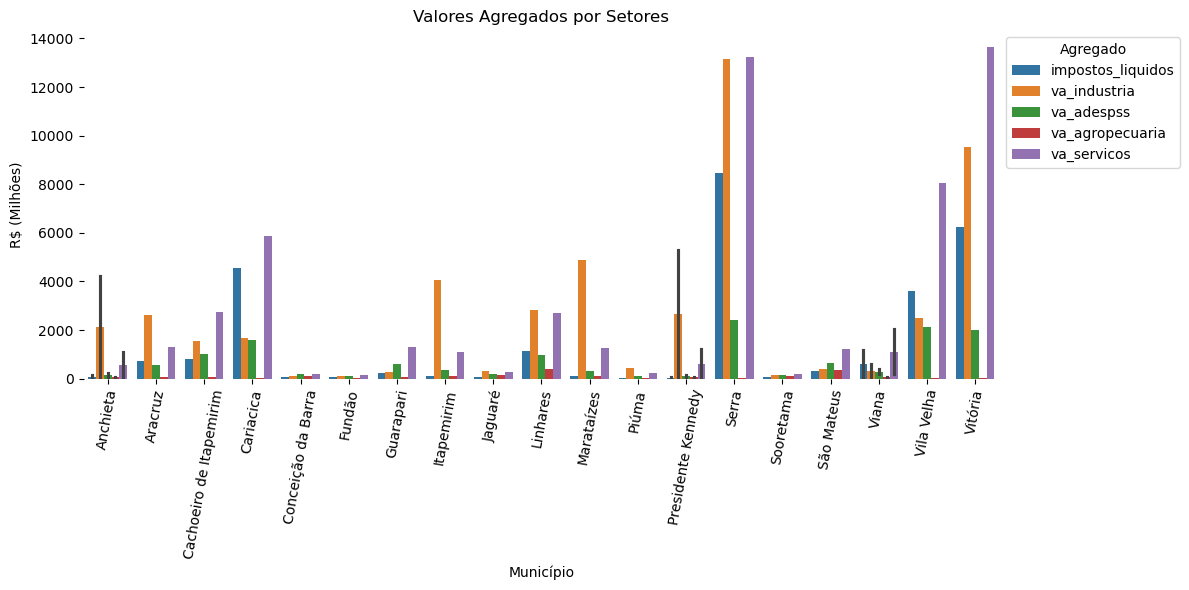

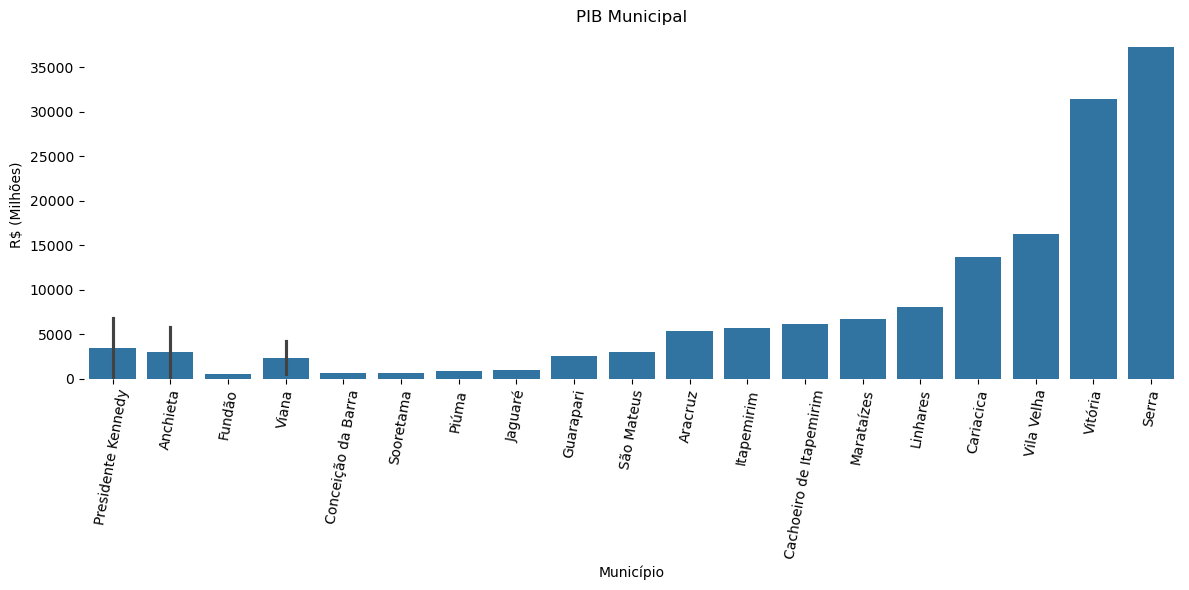

In [29]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Pib Municipios', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])


df = df.to_pandas().sort_values('pib')


# Exemplo de como derreter o DataFrame para visualização
df_melted = df.melt(id_vars=['id_municipio_nome'], 
                          value_vars=['impostos_liquidos', 'va_adespss',
                                      'va_agropecuaria', 'va_industria',  'va_servicos'],
                          var_name='VA', value_name='$').sort_values(['id_municipio_nome','$'])



df_melted['$'] = df_melted['$'] / 1000000
df['pib'] = df['pib'] / 1000000

# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário

# Gerar o gráfico com as barras lado a lado para cada raça
ax = sns.barplot(data=df_melted, x='id_municipio_nome', y='$', hue='VA')
ax.set_title("Valores Agregados por Setores")
ax.set_xlabel("Município")
ax.set_ylabel("R$ (Milhões)")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Agregado')
plt.xticks(rotation=80)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()



# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário

# Gerar o gráfico com as barras lado a lado para cada raça
ax = sns.barplot(data=df, x='id_municipio_nome', y='pib')
ax.set_title("PIB Municipal")
ax.set_xlabel("Município")
ax.set_ylabel("R$ (Milhões)")
plt.xticks(rotation=80)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()




### Transferêcias FUNDEB

id_municipio_nome,uf,mes,ano,transferencias
null,null,i32,null,f64


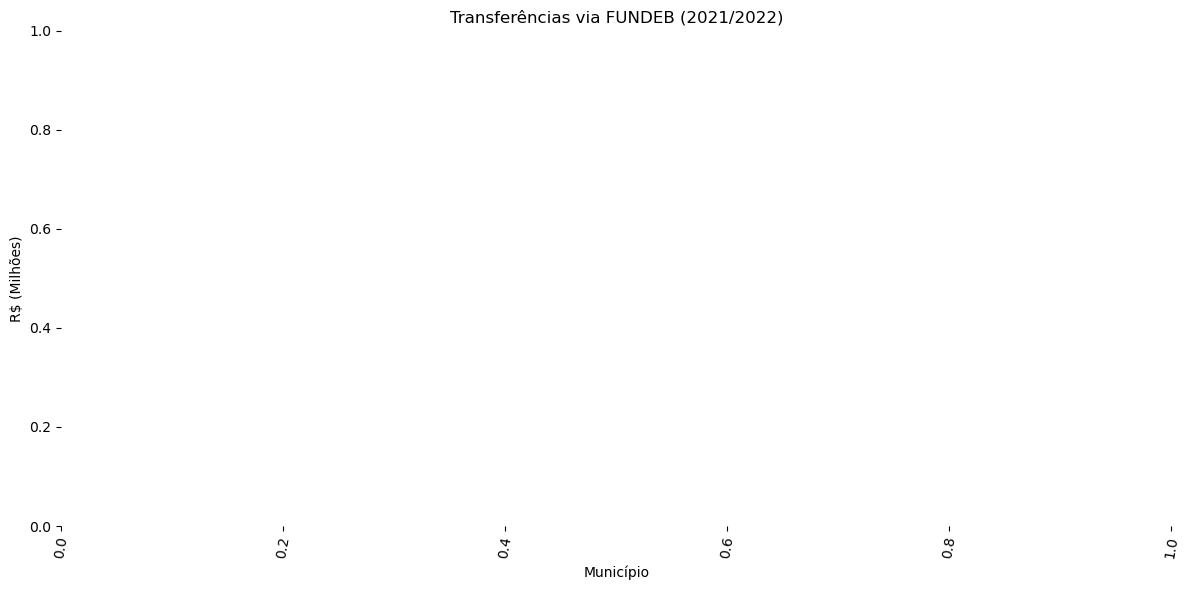

In [30]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Transferencias Fundeb', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])




display(df)

df_tline = df.group_by(['ano', 'id_municipio_nome']) \
          .agg([pl.sum("transferencias").alias("Transferências Fundeb"), 
                ])\
          .sort(['Transferências Fundeb', ], descending=False).to_pandas() 



df_tline['Transferências Fundeb'] = df_tline['Transferências Fundeb'] / 1000000

# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário

# Gerar o gráfico com as barras lado a lado para cada raça
ax = sns.barplot(data=df_tline, x='id_municipio_nome', y='Transferências Fundeb')
ax.set_title("Transferências via FUNDEB (2021/2022)")
ax.set_xlabel("Município")
ax.set_ylabel("R$ (Milhões)")
plt.xticks(rotation=80)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


### Transferências Fundo de Participação dos Municípios

id_municipio_nome,uf,mes,ano,transferencias
null,null,i32,null,f64


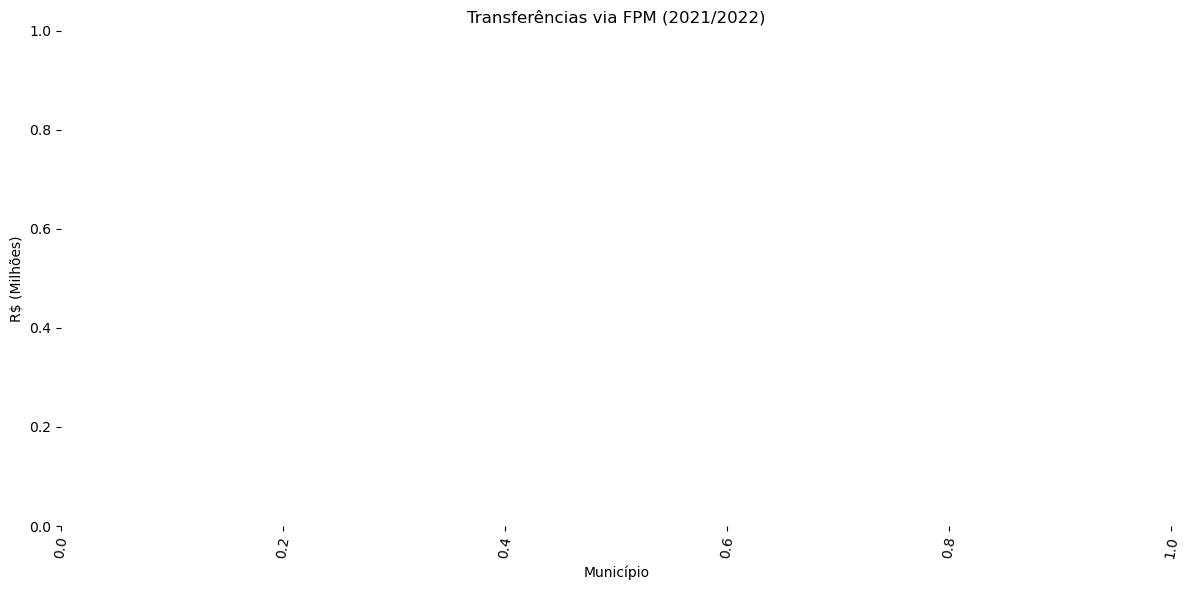

In [31]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Transferencias Fpm', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])




display(df)

df_tline = df.group_by(['ano', 'id_municipio_nome']) \
          .agg([pl.sum("transferencias").alias("Transferências FPM"), 
                ])\
          .sort(['Transferências FPM', ], descending=False).to_pandas() 



df_tline['Transferências FPM'] = df_tline['Transferências FPM'] / 1000000

# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário

# Gerar o gráfico com as barras lado a lado para cada raça
ax = sns.barplot(data=df_tline, x='id_municipio_nome', y='Transferências FPM')
ax.set_title("Transferências via FPM (2021/2022)")
ax.set_xlabel("Município")
ax.set_ylabel("R$ (Milhões)")
plt.xticks(rotation=80)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()